In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\NDA04\Anaconda3\envs\pystan\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [6]:
groups = df.groupby(df["id"])

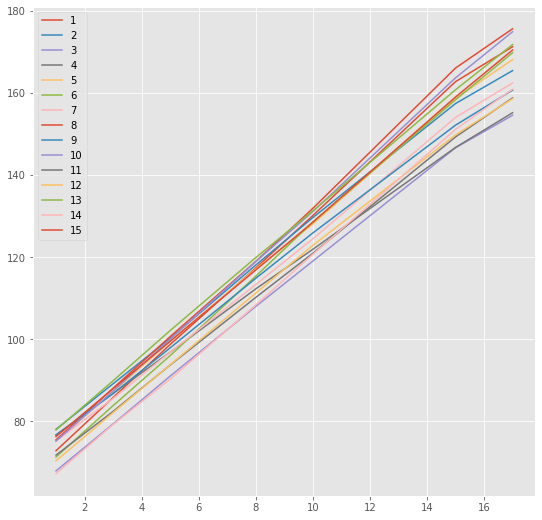

In [7]:
plt.figure(figsize=(9,9))
for name, group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [8]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]],s_Y);
  }
}

"""

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4d8edd4ab0bc54d6d23c466a43569fa NOW.
C:\Users\NDA04\Anaconda3\envs\pystan\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\NDA04\AppData\Local\Temp\tmpsmlrphpi\stanfit4anon_model_c4d8edd4ab0bc54d6d23c466a43569fa_4405080909705909178.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"],"s_id":df["id"]}

In [11]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [12]:
fit

Inference for Stan model: anon_model_c4d8edd4ab0bc54d6d23c466a43569fa.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.78  3.7e-3   0.11   5.55    5.7   5.78   5.85    6.0    910    1.0
b0        68.24    0.03   1.01   66.2  67.61  68.23  68.89  70.31    867    1.0
a_id[1]    0.46  3.7e-3   0.12   0.21   0.38   0.46   0.54   0.71   1128    1.0
a_id[2]    -0.2  3.7e-3   0.12  -0.45  -0.28   -0.2  -0.12   0.04   1102    1.0
a_id[3]    -0.3  3.8e-3   0.13  -0.54  -0.39   -0.3  -0.22  -0.05   1094    1.0
a_id[4]   -0.81  3.9e-3   0.13  -1.06  -0.89   -0.8  -0.72  -0.56   1072    1.0
a_id[5]    0.08  3.8e-3   0.13  -0.17-6.8e-3   0.08   0.16   0.33   1100    1.0
a_id[6]     0.4  3.7e-3   0.13   0.16   0.32    0.4   0.48   0.65   1160    1.0
a_id[7]   -0.22  3.7e-3   0.13  -0.46   -0.3  -0.22  -0.13   0.03   1136    1.0
a_id[8]    

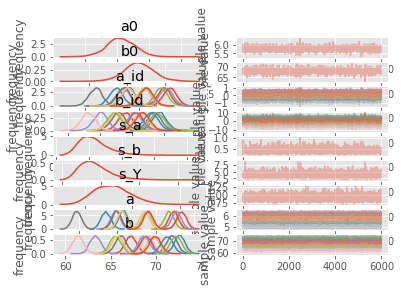

In [13]:
fig = fit.plot()

In [14]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [15]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]

In [20]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025,0.975], axis=0)

In [21]:
df_0 = groups.get_group(1)

In [22]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


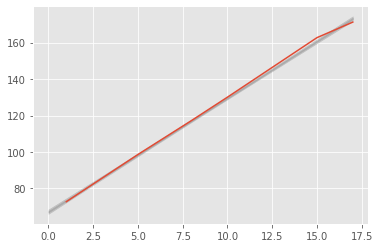

In [23]:
plt.plot(df_0["age"], df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color = "gray")